## Structual transition of single nanocrystals by atom- and time-resolved 3D liquid cell electron microscopy
- Sungsu Kang<sup>1,2</sup>†, Joodeok Kim<sup>1,2</sup>†, Sungin Kim<sup>1,2</sup>†, Hoje Chun<sup>3</sup>, Junyoung Heo<sup>1,2</sup>, Cyril F. Reboul<sup>4</sup>, Rubén Meana-Pañeda<sup>4</sup>, Cong T. S. Van<sup>4</sup>, Hyesung Choi<sup>1,2</sup>, Yunseo Lee<sup>1,2</sup>, Jinho Rhee<sup>1,2</sup>, Minyoung Lee<sup>1,2</sup>, Dohun Kang<sup>1,2</sup>, Byung Hyo Kim<sup>5</sup>, Taeghwan Hyeon<sup>1,2</sup>, Byungchan Han<sup>3</sup>\*, Peter Ercius<sup>6</sup>\*, Won Chul Lee<sup>7</sup>\*, Hans Elmlund<sup>4</sup>\*, Jungwon Park<sup>1,2,8,9</sup>\*

---
<sup>1</sup> School of Chemical and Biological Engineering, Institute of Chemical Processes, Seoul National University, Seoul 08826, Republic of Korea.

<sup>2</sup> Center for Nanoparticle Research, Institute for Basic Science (IBS), Seoul 08826, Republic of Korea.

<sup>3</sup> Department of Chemical and Biomolecular Engineering, Yonsei University, Seoul 03722, Republic of Korea.

<sup>4</sup> National Cancer Institute (NCI), National Institutes of Health (NIH), Frederick, MD 21701, USA.

<sup>5</sup> Department of Material Science and Engineering, Soongsil University, Seoul 06978, Republic of Korea.

<sup>6</sup> Molecular Foundry, Lawrence Berkeley National Laboratory, Berkeley, CA 94720, USA.

<sup>7</sup> Department of Mechanical Engineering, BK21 FOUR ERICA-ACE Center, Hanyang University, Ansan 15588, Republic of Korea.

<sup>8</sup> Institute of Engineering Research, College of Engineering, Seoul National University, Seoul 08826, Republic of Korea.

<sup>9</sup> Advanced Institute of Convergence Technology, Seoul National University, Suwon 16229, Republic of Korea.

† These authors contributed equally.

\* Corresponding authors: jungwonpark@snu.ac.kr (J.P.); hans.elmlund@nih.gov (H.E.); wonchullee@hangyang.ac.kr (W.C.L.); percius@lbl.gov (P.E.); bchan@yonsei.ac.kr (B.H.).

### Introduction
---
This is a code for our paper "Structural transition of single nanocrystals by atom- and time-resolved 3D liquid cell electron microscopy". This code is used to analyze time-series 3D atomic structures of nanocrystals obtained by SINGLE.

This code was tested on python3 (version 3.11) and you need to install necessary modules beforehand.

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import scipy
from scipy.spatial import ConvexHull
from scipy.spatial import cKDTree as KDTree
import boo

/Users/gangsungsu/anaconda3/envs/TEM_denoiser/lib/python3.11/site-packages/boo/boo.py:266: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit#(nopython=True)
/Users/gangsungsu/anaconda3/envs/TEM_denoiser/lib/python3.11/site-packages/boo/boo.py:288: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit#(['complex128[:](complex128[:,:], int64)'], nopython=True)
/User

### Import atomic maps

In [2]:
# element
element = 'Pt'

# name and directory of the pdb file
filename_recon = 'stage1_docked_ATMS.pdb'
dir_recon = './example-maps/'
input_recon = dir_recon + filename_recon

# directory to be saved
save_path = './analysis/'
save_pdb = True

if not os.path.exists(save_path):
    os.makedirs(save_path)

# Import pdb file of an ideal FCC structure for comparison
ideal_fcc = './example-maps/COM_trunc-octa-3_2.7nm.pdb'

# Convert the pdb file into an array
def pdb2array(input_recon):
    # input: pdb file
    # output: numpy array containing x,y,z coordinates
    pdb_recon = [list(map(float, line.split()[6:9])) for line in list(open(input_recon, "r"))]
    array_recon = np.asarray(pdb_recon)

    return array_recon

array_recon = pdb2array(input_recon)
array_ideal = pdb2array(ideal_fcc)

# Estimate diameter of the 3D model using the ConvexHull algorithm
def calculate_diameter(xyz):
    volume = ConvexHull(xyz).volume
    diameter = (volume * 6 / np.pi) ** (1/3)

    return diameter

diameter = calculate_diameter(array_recon)
print('Particle diameter =  %5.3f A' % diameter)


Particle diameter =  19.688 A


### Calculate radial distribution function, g(r)

Text(0, 0.5, 'g(r)')

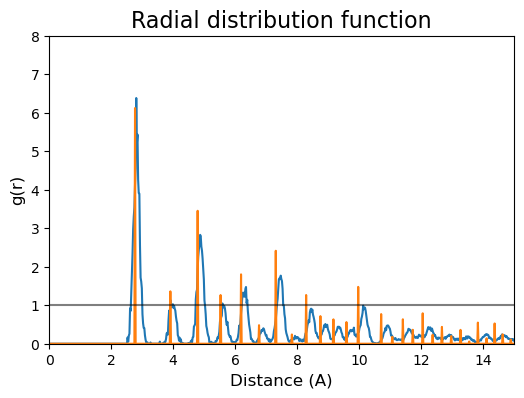

In [3]:
# The first minimum will be used as a cutoff distance for the BOO parameter calculation
def gr_calculation(array_xyz, dr=0.02):
    # inputs
    # array_xyz: 3D atomic coordinates
    # dr: bin size for calculation

    # outputs
    # gr: values of radial distribution function (y)
    # r: distance (x)
    dist = scipy.spatial.distance.pdist(array_xyz)
    dn_i, bin_edges = np.histogram(dist, bins=np.arange(0, np.ceil(max(dist)), dr))
    r = bin_edges + dr / 2
    r = r[:-1]
    dn_i_sum = dn_i.sum()
    dx = np.max(array_xyz[:, 0]) - np.min(array_xyz[:, 0])
    dy = np.max(array_xyz[:, 1]) - np.min(array_xyz[:, 1])
    dz = np.max(array_xyz[:, 2]) - np.min(array_xyz[:, 2])
    R = (dx + dy + dz) / 3 / 2

    gr = np.power(R, 3) / (3 * dr * dn_i_sum) * np.divide(dn_i, np.power(r, 2))

    return gr, r


# Calculate for experimental and ideal 3D maps
gr, r = gr_calculation(array_recon, 0.02)
gr_ideal, r_ideal = gr_calculation(array_ideal, 0.02)

 # Save the result if you want
if save_pdb :
    np.savetxt(os.path.join(save_path, filename_recon.replace('.pdb', '') + '_rdf.csv'), np.stack((r, gr), axis=1))

# Plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title("Radial distribution function", fontsize=16)
ax.plot(r, gr)
ax.plot(r_ideal, gr_ideal / 10) # scale down by 10 times
ax.set_ylim(0, 8)
ax.set_xlim(0, 15)
ax.axhline(y=1, color='k', alpha=0.5)
ax.set_xlabel("Distance (A)", fontsize=12)
ax.set_ylabel("g(r)", fontsize=12)


### Calculate bond orientational order parameter using pyboo
- Pyboo: A Python package to compute bond orientational order parameters, Mathieu Leocmach, 2017, 10.5281/zenodo.1066568, https://github.com/MathieuLeocmach/pyboo

In [4]:
# First minimum of the rdf, which is used as a cutoff distance for calculating BOO parameter
R_max = 3.41    # in A

# Construct the bond network using a maximum distance criteria, just use KDTree indexing because this is fast
tree = KDTree(array_recon, 12)  # spatial indexing
bonds = tree.query_pairs(R_max, output_type='ndarray')  # query

# every particle is considered for bond order parameter calculation, for colloidal systems particles near
# the FOV boundary should be excluded here
inside = np.full(len(array_recon), True)

# calculate the number of neighbours per particle
Nngb = np.zeros(len(array_recon), int)
np.add.at(Nngb, bonds.ravel(), 1)

# calculate 6-fold and 4-fold orientational order and their coarse-grained versions
q6m = boo.bonds2qlm(array_recon, bonds, l=6)
q4m = boo.bonds2qlm(array_recon, bonds, l=4)
Q6m, inside2 = boo.coarsegrain_qlm(q6m, bonds, inside)
Q4m, inside2 = boo.coarsegrain_qlm(q4m, bonds, inside)

# calculate rotational-invariant bond order parameters
q6 = boo.ql(q6m)
q4 = boo.ql(q4m)
Q6 = boo.ql(Q6m)
Q4 = boo.ql(Q4m)

# calculate w6 and w4 which can ease the detection of icosahedral structures
w6 = boo.wl(q6m)
w4 = boo.wl(q4m)
W6 = boo.wl(Q6m)
W4 = boo.wl(Q4m)

def bond_normed_product(qlm, bonds):
    q = boo.ql(qlm)
    return boo.product(qlm[bonds[:, 0]], qlm[bonds[:, 1]]) / (q[bonds[:, 0]] * q[bonds[:, 1]])

s6 = bond_normed_product(q6m, bonds)
C6 = boo.crystallinity(q6m, bonds)
xtal = boo.x_particles(q6m, bonds, value_thr=0.8, nb_thr=np.ceil(Nngb/2+0.01))


### Calculate additional parameters

Fraction of disordered atoms with same or less crystalline bonds than half of the bonds = 0.006
Number of atoms: 314, disordered atoms:  2


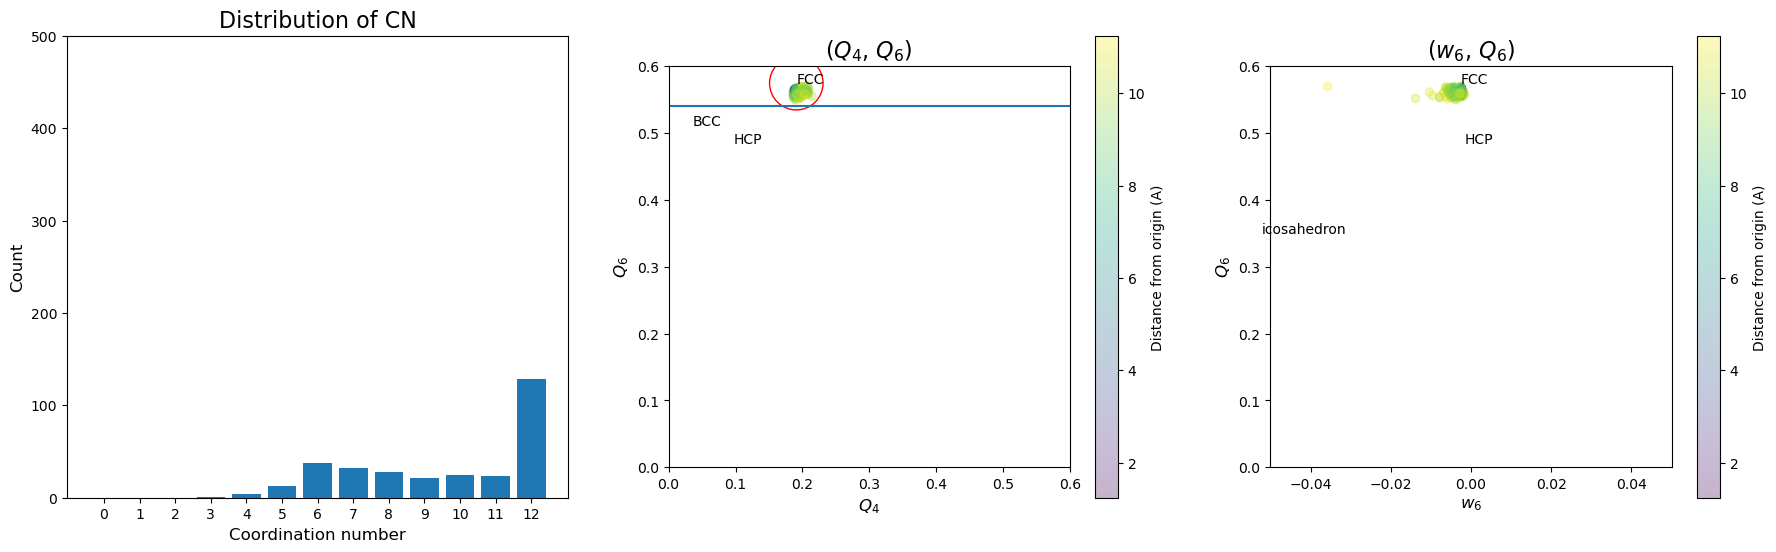

In [5]:
# Distance of each atom from the nanoparticle COM
def distance_from_center(xyz_arr) :
    coord_center = xyz_arr - np.mean(xyz_arr, axis=0)
    dist_center = np.linalg.norm(coord_center, axis=1)

    return dist_center

d_center = distance_from_center(array_recon)

# Show the number of crystalline/disordered atoms
print('Fraction of disordered atoms with same or less crystalline bonds than half of the bonds = %5.3f' % ((len(xtal) - sum(xtal)) / len(xtal)))
print('Number of atoms: %3.0f, disordered atoms: %2.0f' % (len(xtal), len(xtal)-sum(xtal)))

# Calculate mean Pt-Pt distances
dist = scipy.spatial.distance.cdist(array_recon, array_recon)
dist[dist > R_max] = 0
dist[dist == 0] = np.nan
dist_to_NNs = np.nanmean(dist, axis=0)

# Calculate coordination numbers
def numnn(array_xyz, element):
    cdist = scipy.spatial.distance.cdist(array_xyz, array_xyz)
    length = len(array_xyz)
    if element == 'Pt' :
        a = 3.912
    elif element == 'Au' :
        a = 4.0782
    """find nearest neighborhoods and their number for short range order (local BOO parameter) calculation"""
    cutoff = 1.2 * np.sqrt(2) / 2 * a
    nn_arr = np.zeros(length)
    for i in range(length):
        temp = cdist[i][:]
        temp_count = sum(ii < cutoff for ii in temp) - 1
        nn_arr[i] = temp_count

    return nn_arr

def CN_calculation(array_recon, element) :
    nn_array = numnn(array_recon, element)
    counts, bin_edges = np.histogram(nn_array, bins=np.arange(-0.5, max(nn_array) + 1.5, 1))
    bin_centers = np.arange(0, max(nn_array) + 1)

    center = np.mean(array_recon, 0)
    r = np.linalg.norm(array_recon - center, axis=1)

    return bin_centers, counts, r, nn_array

CN_bin_center, CN_count, distance_from_center_CN, nn_array = CN_calculation(array_recon, element)


# Plot some results
def fixed_aspect_ratio(ax, ratio):
    '''
    Set a fixed aspect ratio on matplotlib plots
    regardless of axis units
    '''
    xvals, yvals = ax.get_xlim(), ax.axes.get_ylim()

    xrange = xvals[1]-xvals[0]
    yrange = yvals[1]-yvals[0]
    ax.set_aspect(ratio*(xrange/yrange), adjustable='box')
    

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 6))

# 1. coordination numbers
ax1.set_title("Distribution of CN", fontsize=16)
ax1.bar(CN_bin_center, CN_count)
ax1.set_xticks(np.arange(0, max(CN_bin_center) + 1, 1))
ax1.set_ylim(0, 500)
ax1.set_xlabel("Coordination number", fontsize=12)
ax1.set_ylabel("Count", fontsize=12)


# 2. Coarse-grained bond orientational order parameter (Q4,Q6)
plot2 = ax2.scatter(Q4, Q6, c=d_center, alpha=0.3, cmap='viridis')
ax2.set_title("($Q_{4}$, $Q_{6}$)", fontsize=16)
cbar2 = plt.colorbar(plot2, ax=ax2)
cbar2.set_label('Distance from origin (A)', rotation=90)
ax2.set_ylim(0, 0.6)
ax2.set_xlim(0, 0.6)
ax2.set_xlabel(r'$Q_{4}$', fontsize=12)
ax2.set_ylabel(r'$Q_{6}$', fontsize=12)
ax2.axhline(y=0.54)
ax2.text(0.1909, 0.5745, 'FCC')
ax2.text(0.0972, 0.4848, 'HCP')
ax2.text(0.0364, 0.5107, 'BCC')
ax2.add_patch(plt.Circle((0.1909, 0.5745), 0.040, color='r', fill=False))
fixed_aspect_ratio(ax2, 1)

# 3. (w6,Q6)
plot3 = ax3.scatter(w6, Q6, c=d_center, alpha=0.3, cmap='viridis')
ax3.set_title("($w_{6}$, $Q_{6}$)", fontsize=16)
cbar3 = plt.colorbar(plot3, ax=ax3)
cbar3.set_label('Distance from origin (A)', rotation=90)
ax3.set_ylim(0, 0.6)
ax3.set_xlim(-0.05, 0.05)
ax3.set_xlabel(r'$w_{6}$', fontsize=12)
ax3.set_ylabel(r'$Q_{6}$', fontsize=12)
ax3.text(-0.002626, 0.5745, 'FCC')
ax3.text(-0.00149, 0.4848, 'HCP')
ax3.text(-0.05213, 0.35, 'icosahedron')
fixed_aspect_ratio(ax3, 1)

plt.show()

#### Save pdb files with parameters in the b-factor block and csv files


In [6]:
def matrix_to_pdb(mat,outfile):
    out_f = open(outfile, 'w')

    n = 1
    for line in mat:
        if len(line) > 3:
            param1 = line[3]
        else :
            param1 = 1

        if len(line) > 4:
            param2 = line[4]
        else :
            param2 = 1

        coord = line[0:3]
        if n < 1000:
            X = 'X'
            i = n
        elif n < 1999:
            X = 'Y'
            i = n - 999
        else:
            X = 'Z'
            i = n - 1998

        line = "ATOM    " + "%3.0f" % i + "  OW  WAT " + X + " " + "%3.0f" % i + "    " + "%8.3f" % coord[0] + "%8.3f" % \
               coord[1] + "%8.3f" % coord[2] + "%6.3f" % param1 + "%6.3f" % param2 + "           O\n"
        out_f.write(line)
        n = n + 1

    line='END'
    out_f.write(line)

    out_f.flush()
    out_f.close()


def write_pdb_w_arr(xyz_arr, arr, savepath='./test.pdb'):
    length = len(xyz_arr)
    output_arr = np.zeros([length, 5])
    charge_arr = np.ones(length) * 0.1
    output_arr[:, :-2] = xyz_arr
    output_arr[:, -2] = charge_arr
    output_arr[:, -1] = arr
    matrix_to_pdb(output_arr, savepath)

    return output_arr


if save_pdb :
    # pdb files
    output = write_pdb_w_arr(array_recon, Q6, save_path + filename_recon + '_Q6.pdb')
    output = write_pdb_w_arr(array_recon, Q4, save_path + filename_recon + '_Q4.pdb')
    output = write_pdb_w_arr(array_recon, Nngb, save_path + filename_recon + '_CN.pdb')
    output = write_pdb_w_arr(array_recon, C6, save_path + filename_recon + '_C6.pdb')
    output = write_pdb_w_arr(array_recon, xtal, save_path + filename_recon + '_xtal_0.8.pdb')
    output = write_pdb_w_arr(array_recon, dist_to_NNs, save_path + filename_recon + '_r_to_NNs.pdb')

    # csv files
    np.savetxt(os.path.join(save_path, filename_recon + '_BOO.csv'),np.stack((d_center, Q4, Q6, w6), axis=1))
    np.savetxt(os.path.join(save_path, filename_recon + '_s6.csv'), s6)
    np.savetxt(os.path.join(save_path, filename_recon + '_r_to_NNs.csv'), np.stack((d_center, dist_to_NNs, Nngb), axis=1))
